# PCML Project-1 ~ Team #60

## Initial Python Imports

In [17]:
# Useful starting lines
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import datetime

from costs import compute_loss

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [18]:
from proj1_helpers import *
from helpers import *

DATA_TRAIN_PATH = "../Data/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

#print the shape of the offset x matrix.
print('y shape: ',y.shape)
print('original tX shape: ',tX.shape)
print('ids shape: ',ids.shape)

y shape:  (250000,)
original tX shape:  (250000, 30)
ids shape:  (250000,)


## Data preprocessing

### Standardization

In [19]:
#standardization
#tX, mean_x, std_x = standardize(tX, mean_x=None, std_x=None)
tX, mean_x, std_x = standardize_outliers(tX)
print('standardized tX shape: ',tX.shape)
print('tX mean shape: ',mean_x.shape)
print('tX std shape: ',std_x.shape)

250000 30
(30,)
(30,)
standardized tX shape:  (250000, 31)
tX mean shape:  (30,)
tX std shape:  (30,)


### Analysis of output y

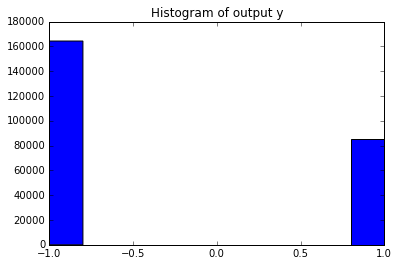

In [20]:
# Histogram of output y
plt.hist(y, bins=10, align='mid')
plt.title("Histogram of output y")
plt.show()

### Analysis of y as a function of all its features (one by one)

feature:  0


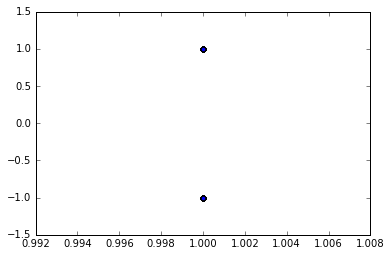

feature:  1


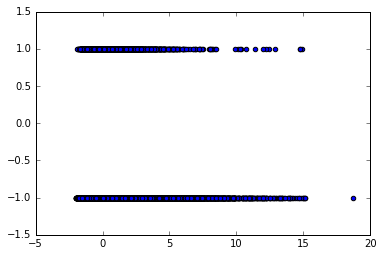

feature:  2


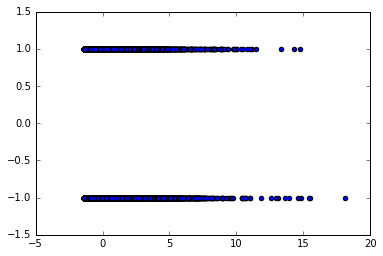

feature:  3


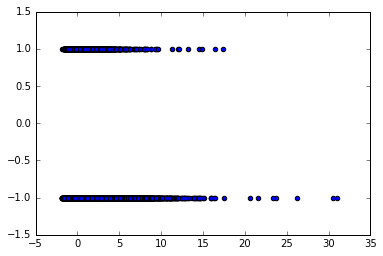

feature:  4


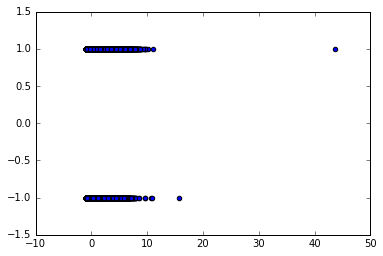

feature:  5


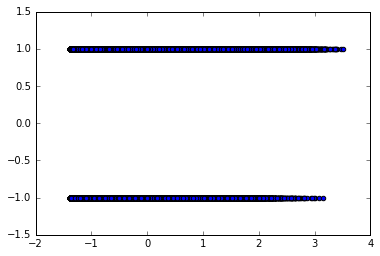

feature:  6


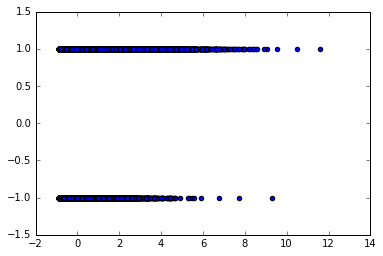

feature:  7


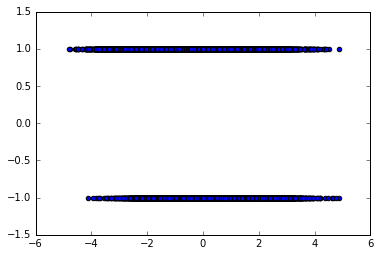

feature:  8


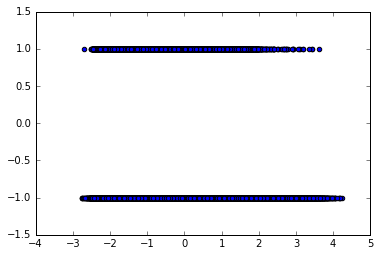

feature:  9


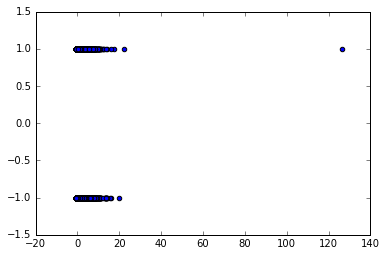

feature:  10


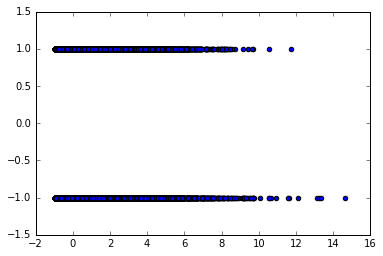

feature:  11


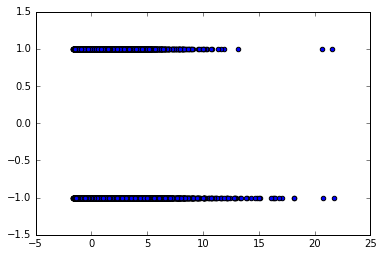

feature:  12


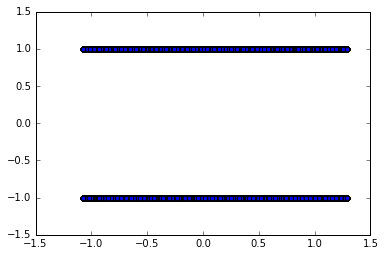

feature:  13


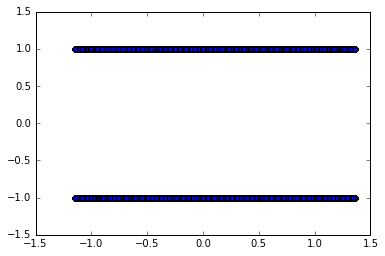

feature:  14


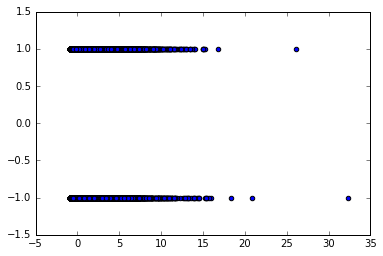

feature:  15


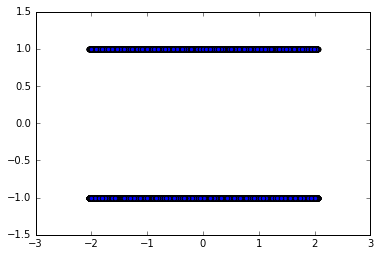

feature:  16


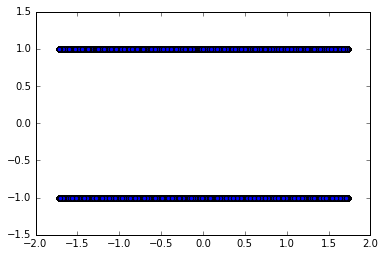

feature:  17


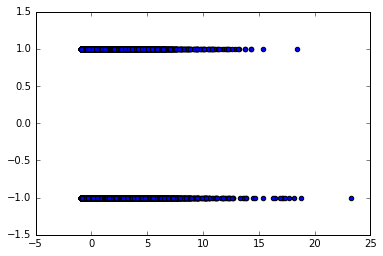

feature:  18


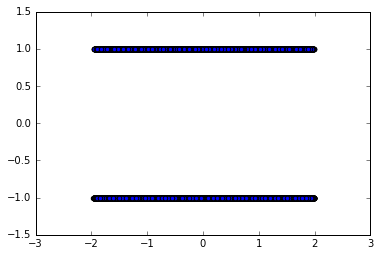

feature:  19


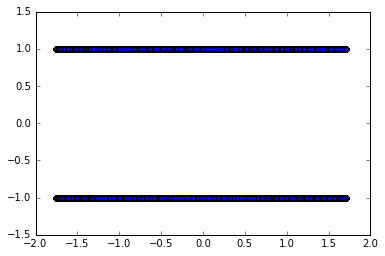

feature:  20


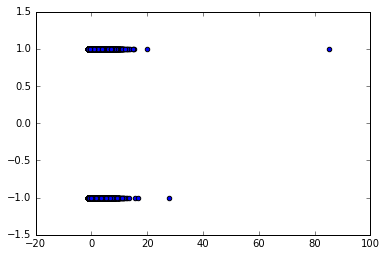

feature:  21


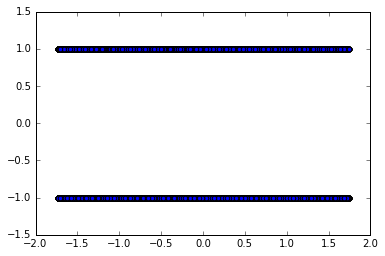

feature:  22


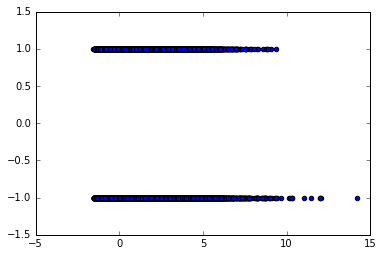

feature:  23


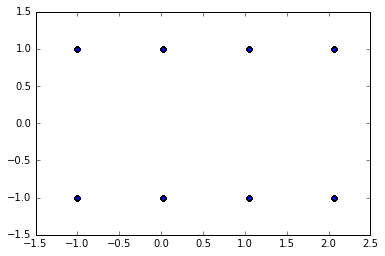

feature:  24


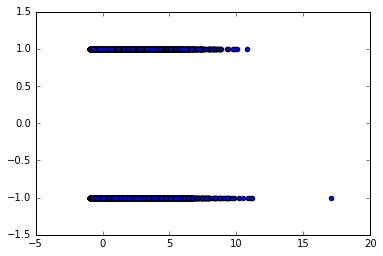

feature:  25


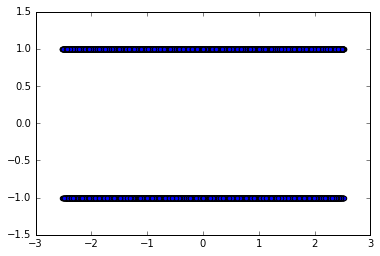

feature:  26


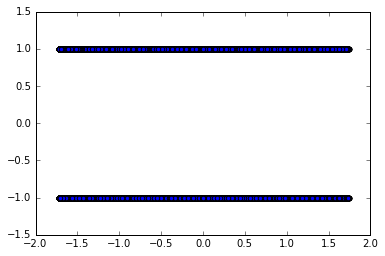

feature:  27


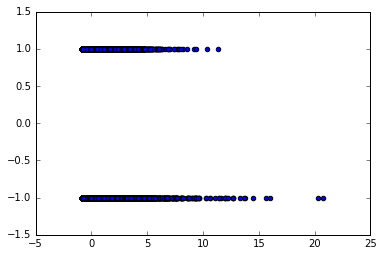

feature:  28


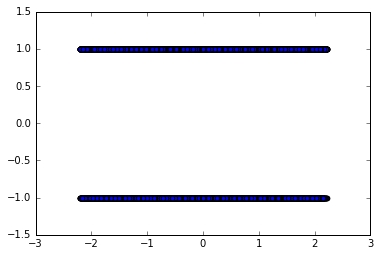

feature:  29


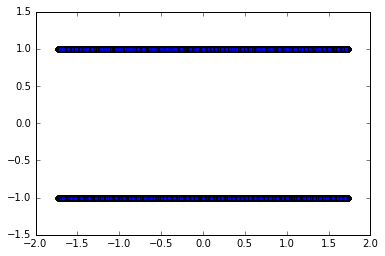

feature:  30


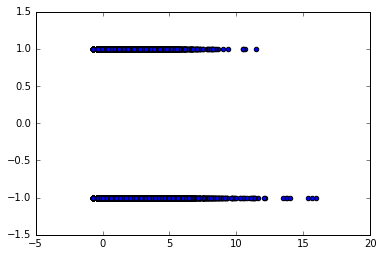

In [21]:
# Analyse y as a function of all the other features (one by one)
number_of_params = tX.shape[1]
for feature in range(tX.shape[1]):
    print('feature: ',feature)
    plt.scatter(tX[:,feature], y)
    plt.show()

## Linear regression using gradient descent

In [22]:
from gradient_descent import least_squares_GD

# Define the parameters of the algorithm.
max_iters = 1000
gamma = 0.01

# Initialization
w_initial = np.zeros(tX.shape[1])

# Start gradient descent.
# start_time = datetime.datetime.now()
gradient_losses, gradient_ws = least_squares_GD(y, tX, w_initial, gamma, max_iters)
# end_time = datetime.datetime.now()


Gradient Descent(0/999): loss=0.5
Gradient Descent(1/999): loss=0.4950407184558149
Gradient Descent(2/999): loss=0.49036020369442296
Gradient Descent(3/999): loss=0.4859346352347421
Gradient Descent(4/999): loss=0.48174268044681484
Gradient Descent(5/999): loss=0.4777652151356388
Gradient Descent(6/999): loss=0.47398507628395414
Gradient Descent(7/999): loss=0.4703868432215644
Gradient Descent(8/999): loss=0.46695664392324954
Gradient Descent(9/999): loss=0.4636819835211782
Gradient Descent(10/999): loss=0.4605515924568521
Gradient Descent(11/999): loss=0.45755529199721845
Gradient Descent(12/999): loss=0.45468387510428165
Gradient Descent(13/999): loss=0.4519290008814095
Gradient Descent(14/999): loss=0.44928310102613866
Gradient Descent(15/999): loss=0.44673929690183095
Gradient Descent(16/999): loss=0.4442913260018178
Gradient Descent(17/999): loss=0.4419334767221679
Gradient Descent(18/999): loss=0.43966053048511433
Gradient Descent(19/999): loss=0.4374677103664299
Gradient Descent

## Linear regression using stochastic gradient descent

In [24]:
from stochastic_gradient_descent import least_squares_SGD

# Define the parameters of the algorithm.
max_iters = 1000
gamma = 0.01
batch_size = 50

# Initialization
w_initial = np.zeros(tX.shape[1])

# Start SGD.
# start_time = datetime.datetime.now()
stoch_gradient_losses, stoch_gradient_ws = least_squares_SGD(y, tX, w_initial, batch_size, gamma, max_iters)
# end_time = datetime.datetime.now()

Stochastic Gradient Descent(0/999): loss=0.5
Stochastic Gradient Descent(1/999): loss=0.4972981481347541
Stochastic Gradient Descent(2/999): loss=0.49604890080647285
Stochastic Gradient Descent(3/999): loss=0.49099015157080333
Stochastic Gradient Descent(4/999): loss=0.48612693419014197
Stochastic Gradient Descent(5/999): loss=0.4814615378846263
Stochastic Gradient Descent(6/999): loss=0.47978930850833446
Stochastic Gradient Descent(7/999): loss=0.477508268568455
Stochastic Gradient Descent(8/999): loss=0.47201119981914236
Stochastic Gradient Descent(9/999): loss=0.4662162596039069
Stochastic Gradient Descent(10/999): loss=0.4630949963203841
Stochastic Gradient Descent(11/999): loss=0.45955221559508364
Stochastic Gradient Descent(12/999): loss=0.45622861351825633
Stochastic Gradient Descent(13/999): loss=0.4542782943516552
Stochastic Gradient Descent(14/999): loss=0.4528454146023783
Stochastic Gradient Descent(15/999): loss=0.44840547460459484
Stochastic Gradient Descent(16/999): loss=

In [25]:
i = 0
min_loss = 100
min_i = -1
for l in stoch_gradient_losses:
    if l < min_loss:
        min_loss = l
        min_i = i
    i = i+1
    print(l)

print()
print('min loss: ',min_loss)
print('min index: ',min_i)

0.5
0.497298148135
0.496048900806
0.490990151571
0.48612693419
0.481461537885
0.479789308508
0.477508268568
0.472011199819
0.466216259604
0.46309499632
0.459552215595
0.456228613518
0.454278294352
0.452845414602
0.448405474605
0.444320944105
0.443738343495
0.441416806195
0.439046343754
0.436623363589
0.434370365608
0.431932848807
0.42884038589
0.426383586343
0.423968759388
0.421905793478
0.420833321048
0.420446782894
0.41823658099
0.417408615519
0.416437339201
0.415159025113
0.414645384352
0.413318169219
0.412020004564
0.410266393467
0.408532791044
0.407620675078
0.406491369748
0.405222271191
0.404700832871
0.404084639135
0.403220421295
0.401451732748
0.400279635551
0.399159003673
0.397988633858
0.39761722257
0.396960357257
0.396137413873
0.395508591005
0.394297855834
0.392953848365
0.391825821709
0.391228685836
0.390435087876
0.389719305913
0.389504228496
0.388916802422
0.388327608344
0.388045249697
0.387160526226
0.38623044762
0.385061575076
0.384349323733
0.383916249711
0.3832413820

## Least squares regression using normal equations

In [26]:
from least_squares import least_squares

# start_ls_time = datetime.datetime.now()
ls_wopt, ls_loss = least_squares(y,tX)
# end_ls_time = datetime.datetime.now()
print('loss=',ls_loss)
print('parameters w: ',ls_wopt)

loss= 0.340409452162
parameters w:  [ -3.14664000e-01   1.04652995e-02  -2.54719228e-01  -2.63502968e-01
  -1.10181135e-03   4.05482642e-02   1.67176106e-01   8.97553275e-03
   2.82008766e-01  -2.81502578e-02  -3.29279652e+02  -1.88141151e-01
   1.18065030e-01   1.42232505e-01   6.39663558e+01  -7.79460474e-04
  -8.30656823e-04   6.30821834e+01  -8.61168797e-04   2.51791347e-03
   1.03659311e-01   9.33786062e-04  -4.70019028e-02   4.17575954e-02
  -6.14055754e-02   8.39840624e-04   2.43612108e-04  -6.79446901e-02
   2.89296903e-03  -3.23605722e-03   2.78944548e+02]


## Ridge regression using normal equations

In [27]:
from ridge_regression import ridge_regression

# lambdas = np.logspace(-3, 1, 10)      
# φ_x = build_poly(x, degree)
# x_train, x_test, y_train, y_test = split_data(tX, y, ratio, seed)
    
#     for lamb in lambdas:

w_ridge = ridge_regression(y, tX, 0.01)
err = compute_loss(y, tX, w_ridge)

print('loss: ',err)
print('parameters w: ',w_ridge)

# rmse_tr = np.sqrt(2*compute_loss(y, tX, w_ridge))
# rmse_te = np.sqrt(2*compute_loss(y, tX, w_ridge))


loss:  0.340878093545
parameters w:  [-0.30849412  0.00153899 -0.24496998 -0.21768684  0.01203368  0.06031587
  0.13160635 -0.00917972  0.2500789  -0.02897492  0.04814293 -0.16026933
  0.11844037  0.12989335  0.16957554 -0.00087384 -0.00108577  0.23112678
 -0.00078014  0.00253355  0.08817857  0.00113331 -0.04116437  0.03541982
 -0.05069639  0.00066024  0.00035635 -0.05766349  0.00267076 -0.00282404
 -0.03397273]


## Logistic regression using gradient descent or SGD

In [ ]:
from helpers import de_standardize
from logistic_regression import learning_by_gradient_descent, calculate_loss
from plots import visualization

def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 30820
    threshold = 1e-8
    gamma = 0.000000001
    losses = []

    # build tx
    tx = x
    w = np.zeros((tx.shape[1], 1))
    
    print('tx: ',tx.shape)
    print('w: ',w.shape)
    print('y: ',y.shape)

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 1000 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        # converge criteria
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    print("The loss={l}".format(l=calculate_loss(y, tx, w)))

logistic_regression_gradient_descent_demo(y, tX)

tx:  (250000, 31)
w:  (31, 1)
y:  (250000,)
Current iteration=0, the loss=173286.79513998624
Current iteration=1000, the loss=-9602782272.889833


## Regularized logistic regression using gradient descent or SGD

## Full testing

In [16]:
from test import test

test(y, tX, 0.1)

0.683333333333
0.683333333333


## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = "../Data/test.csv" # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)